This is the xgboost algorithim

In [1]:
!pip install xgboost shap

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier

In [3]:
model_data_cleaned = pd.read_excel("model_data_cleaned.xlsx")

df = model_data_cleaned.copy()

X = df.drop(columns=["target_default_30"])
y = df["target_default_30"]



In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [5]:
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

categorical_cols

['Declared_accommodation_type']

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)

In [7]:
X_train_processed = preprocessor.fit_transform(X_train)

classifier = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    max_depth=5,
    min_child_weight=1,
    gamma=0.1,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    max_delta_step=5,
    reg_lambda=10.0,
    reg_alpha=10,
    random_state=42
)

classifier.fit(X_train_processed, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [8]:
X_test_processed = preprocessor.transform(X_test)

y_pred = classifier.predict(X_test_processed)
y_proba = classifier.predict_proba(X_test_processed)[:, 1]  

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

Confusion Matrix:
 [[531   0]
 [ 20   0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       531
           1       0.00      0.00      0.00        20

    accuracy                           0.96       551
   macro avg       0.48      0.50      0.49       551
weighted avg       0.93      0.96      0.95       551

ROC AUC: 0.9739171374764595


c:\Users\justo\ML_REV\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\justo\ML_REV\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\justo\ML_REV\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Huge overfitting! 

We can change the weights of misclassifying using: scale_pos_weight

In [9]:
num_pos = sum(y_train == 1)
num_neg = sum(y_train == 0)
scale_pos_weight = num_neg / num_pos
print("scale_pos_weight:", scale_pos_weight)

scale_pos_weight: 26.319148936170212


In [10]:
classifier = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    max_depth=5,
    min_child_weight=1,
    gamma=0.1,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    max_delta_step=5,
    reg_lambda=10.0,
    reg_alpha=10,
    random_state=42,
    scale_pos_weight=scale_pos_weight   
)

classifier.fit(X_train_processed, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [11]:
X_test_processed = preprocessor.transform(X_test)

y_pred = classifier.predict(X_test_processed)
y_proba = classifier.predict_proba(X_test_processed)[:, 1]  

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

Confusion Matrix:
 [[504  27]
 [  1  19]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97       531
           1       0.41      0.95      0.58        20

    accuracy                           0.95       551
   macro avg       0.71      0.95      0.77       551
weighted avg       0.98      0.95      0.96       551

ROC AUC: 0.9788135593220338


This model is much better than the other 2. Additionally the ROC AUC is much much higher. 

We can play around with this model by changing the threshold. 

If we create a cost for each incorrect classification, we can "simulate" the costs of being incorrect. This is a very basic implementation: 

In [12]:
cost_fp = 500   # False positive: wrongly flagged as defaulter
cost_fn = 5000  # False negative: missed actual defaulter

best_threshold = 0.5
min_total_cost = float("inf")

thresholds = np.arange(0.05, 0.95, 0.05)
costs = []

for thresh in thresholds:
    y_pred_thresh = (y_proba > thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
    total_cost = fp * cost_fp + fn * cost_fn
    costs.append(total_cost)

    if total_cost < min_total_cost:
        min_total_cost = total_cost
        best_threshold = thresh

print(f"\n Best Threshold: {best_threshold:.2f} with Minimum Cost: ${min_total_cost:,}")


 Best Threshold: 0.65 with Minimum Cost: $16,500


This is the threshold which minimises the cost. 

In [ ]:
threshold = best_threshold

y_proba = classifier.predict_proba(X_test_processed)[:, 1]

y_pred = (y_proba > threshold).astype(int)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

Confusion Matrix:
 [[508  23]
 [  1  19]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98       531
           1       0.45      0.95      0.61        20

    accuracy                           0.96       551
   macro avg       0.73      0.95      0.79       551
weighted avg       0.98      0.96      0.96       551

ROC AUC: 0.9788135593220338


In [34]:
threshold = 0.1

y_proba = classifier.predict_proba(X_test_processed)[:, 1]

y_pred = (y_proba > threshold).astype(int)
print(f'Threshold = {threshold}')
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

Threshold = 0.1
Confusion Matrix:
 [[474  57]
 [  1  19]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94       531
           1       0.25      0.95      0.40        20

    accuracy                           0.89       551
   macro avg       0.62      0.92      0.67       551
weighted avg       0.97      0.89      0.92       551

ROC AUC: 0.9788135593220338


In [35]:
threshold = 0.9

y_proba = classifier.predict_proba(X_test_processed)[:, 1]

y_pred = (y_proba > threshold).astype(int)
print(f'Threshold = {threshold}')
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

Threshold = 0.9
Confusion Matrix:
 [[526   5]
 [ 11   9]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       531
           1       0.64      0.45      0.53        20

    accuracy                           0.97       551
   macro avg       0.81      0.72      0.76       551
weighted avg       0.97      0.97      0.97       551

ROC AUC: 0.9788135593220338


In [32]:
importances = classifier.feature_importances_

onehot_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
numeric_columns = [col for col in X_train.columns if col not in categorical_cols]
feature_names = np.concatenate([onehot_columns, numeric_columns])

if len(feature_names) != len(importances):
    print(f"Mismatch: {len(feature_names)} features vs {len(importances)} importances")
else:
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    print(feature_importance_df.head(10)) 

                                            Feature  Importance
6                                               APR    0.427257
13               Gambling_transactions_last_90_days    0.110232
14                     ATM_withdrawals_last_90_days    0.068609
2   Declared_accommodation_type_Living with Parents    0.045102
10                                 Days_as_customer    0.038954
12                             Min_bal_last_30_days    0.038389
11                     Transactions_in_last_30_days    0.035917
5                               Term_at_origination    0.035407
15                               Other_credit_lines    0.032713
8                                        Age to Use    0.031754


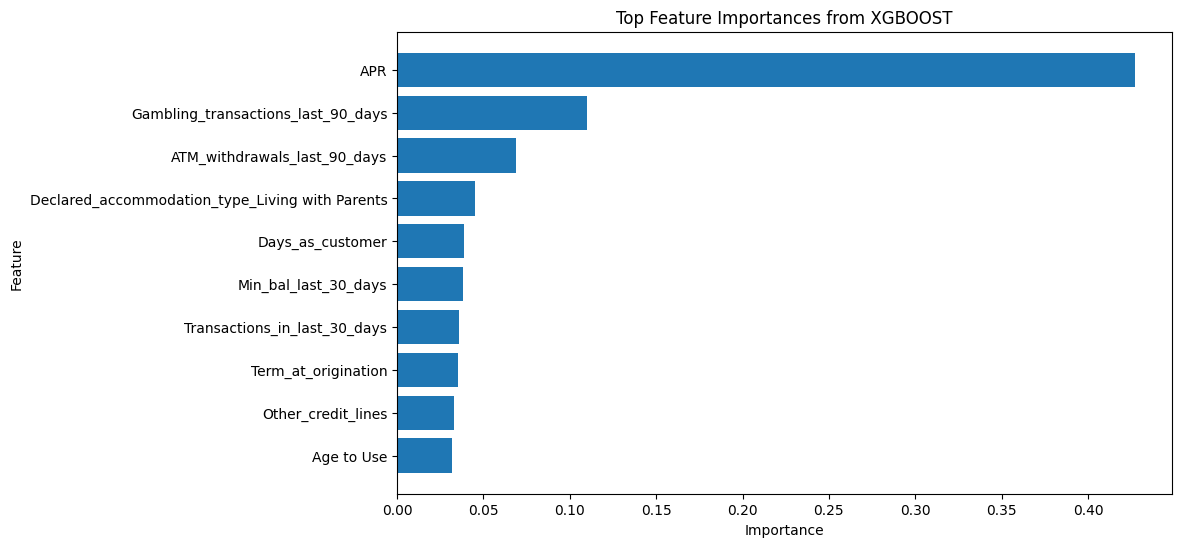

In [14]:
import matplotlib.pyplot as plt

N = 10
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'].head(N), feature_importance_df['Importance'].head(N))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top Feature Importances from XGBOOST')
plt.gca().invert_yaxis() 
plt.show()

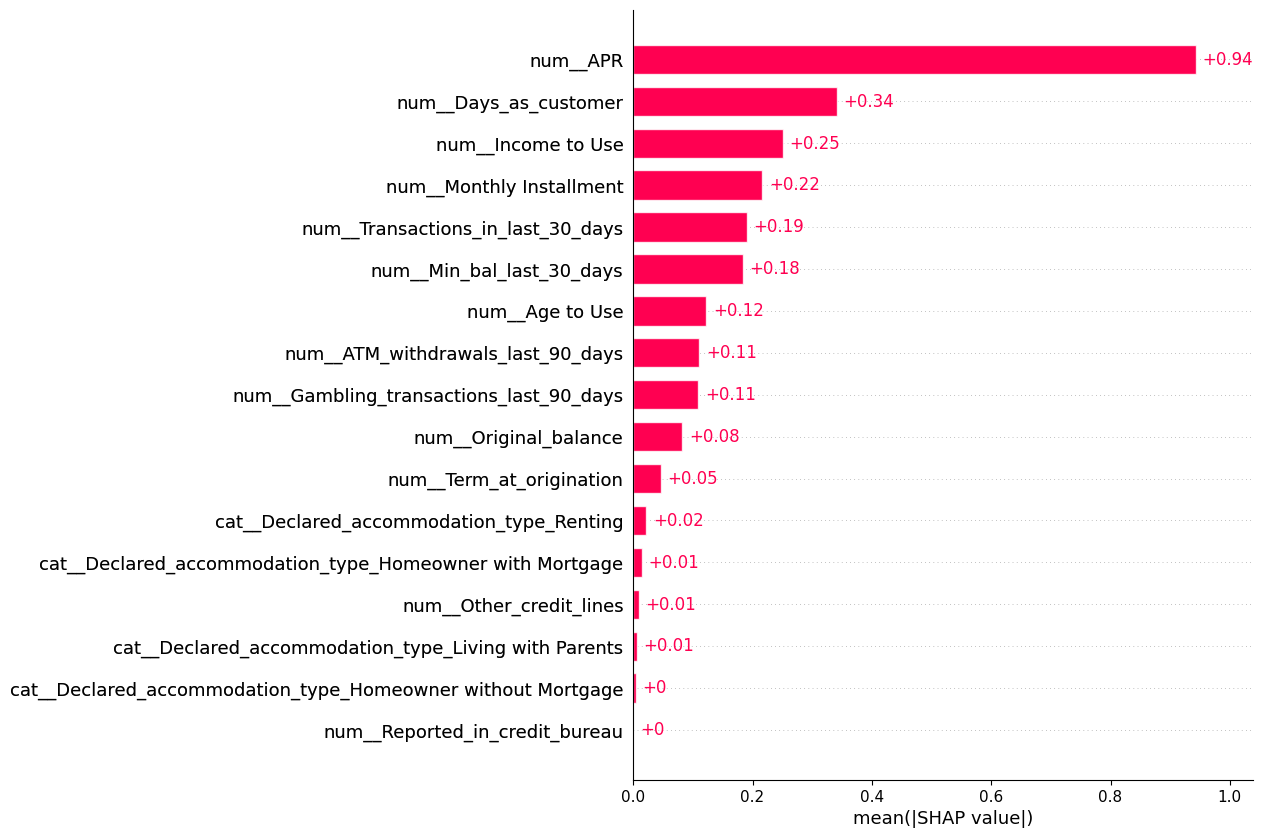

In [ ]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

feature_names = preprocessor.get_feature_names_out()

X_test_df = pd.DataFrame(X_test_processed, columns=feature_names)

explainer = shap.Explainer(classifier, X_test_df, model_output="raw")

shap_values = explainer(X_test_df)

shap.plots.bar(shap_values, max_display=20)

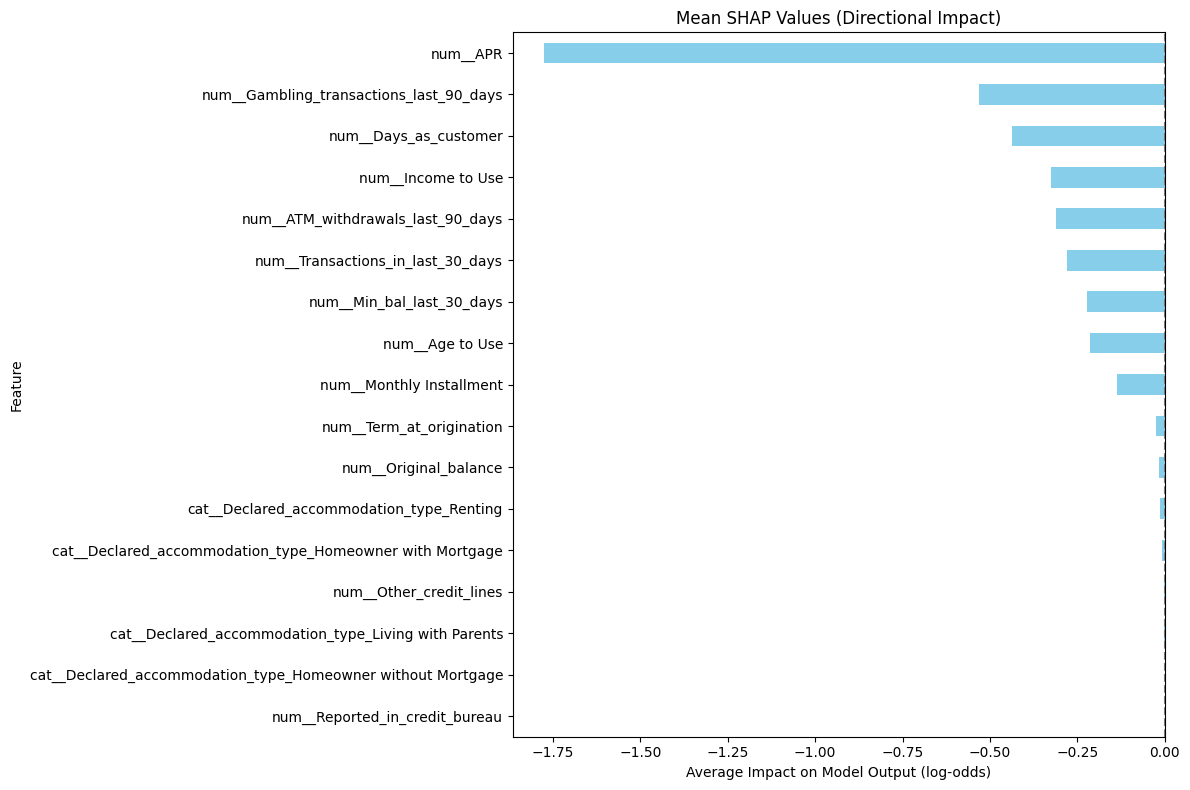

In [17]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

# Get SHAP values (already computed, directional — not abs)
explainer = shap.TreeExplainer(classifier, model_output='raw')
shap_values = explainer.shap_values(X_test_df)

# Calculate mean SHAP value per feature (signed)
mean_shap = np.mean(shap_values, axis=0)

# Create DataFrame for plotting
shap_df = pd.DataFrame({
    'Feature': X_test_df.columns,
    'Mean_SHAP': mean_shap
}).sort_values(by='Mean_SHAP', key=abs, ascending=False)  # Sort by absolute impact

# Plot
plt.figure(figsize=(12, 8))
shap_df.head(20).set_index("Feature")["Mean_SHAP"].plot(kind='barh', color='skyblue')
plt.title("Mean SHAP Values (Directional Impact)")
plt.xlabel("Average Impact on Model Output (log-odds)")
plt.axvline(0, color='gray', linestyle='--')
plt.gca().invert_yaxis()  # Most important feature on top
plt.tight_layout()
plt.show()



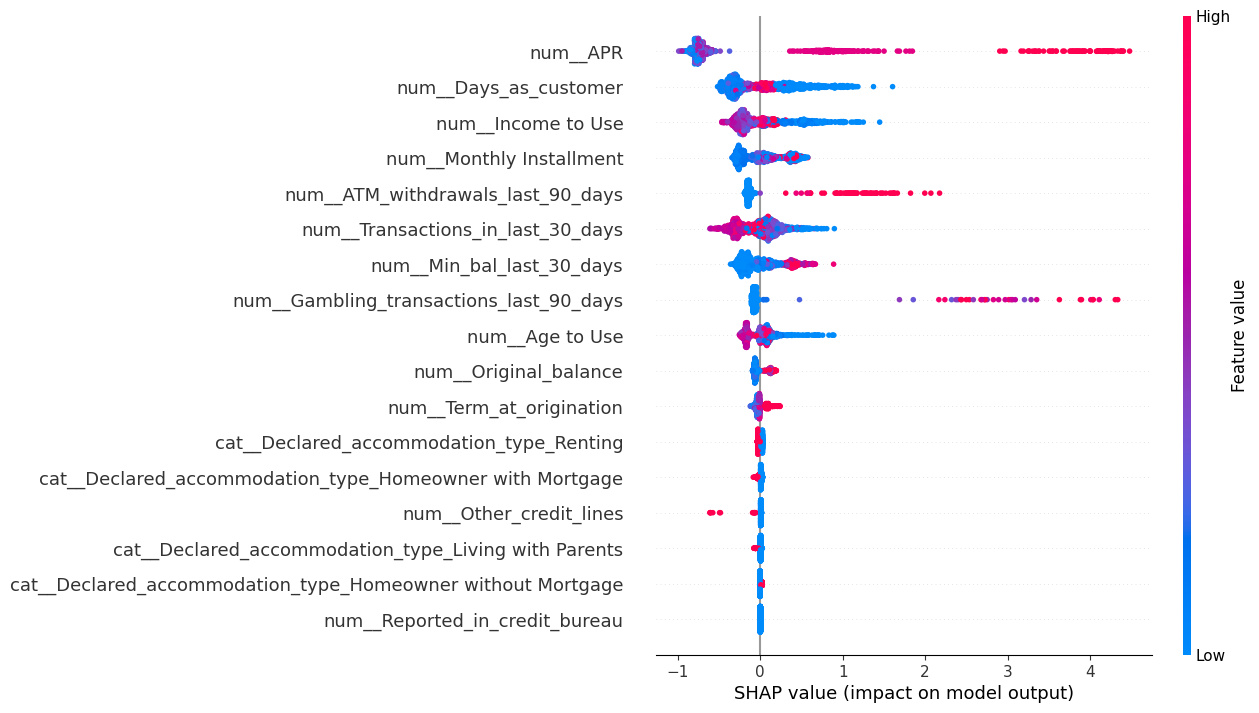

In [ ]:
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names) 

explainer = shap.Explainer(classifier, X_train_df)

shap_values = explainer(X_train_df)

shap.plots.beeswarm(shap_values, max_display=20)

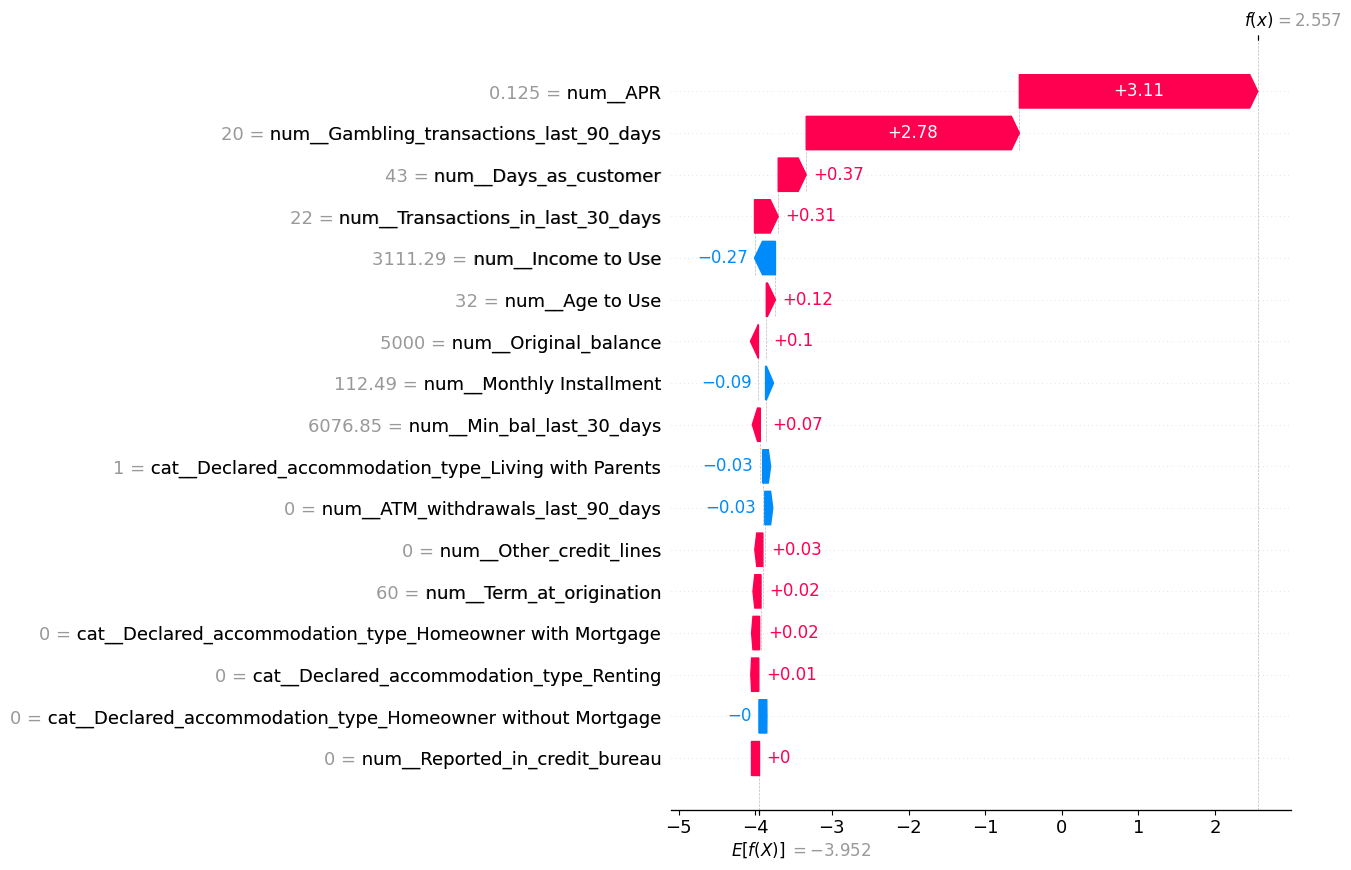

In [33]:
explainer = shap.Explainer(classifier, X_test_df)

# Compute SHAP values for test set
shap_values = explainer(X_test_df)

# Pick an observation to explain (e.g., the first test sample)
i = 0  # change index to look at another sample

# Create waterfall plot
shap.plots.waterfall(shap_values[i], max_display=20)